**Table of contents**<a id='toc0_'></a>    
- [1 - Preparação do Ambiente de Desenvolvimento](#toc1_1_)    
    - [Preparação do ambiente](#toc1_1_1_)    
      - [IDEs utilizada](#toc1_1_1_1_)    
      - [Criar ambiente virtual](#toc1_1_1_2_)    
      - [Ativar .venv](#toc1_1_1_3_)    
  - [2 - Data Undesrtanting](#toc1_2_)    
    - [Data Schema](#toc1_2_1_)    
  - [3 - Preparação dos Dados](#toc1_3_)    
    - [Instalando bibliotecas e componentes necessários](#toc1_3_1_)    
    - [Funções personalizadas para apoio](#toc1_3_2_)    
    - [Data Schema](#toc1_3_3_)    
    - [Ajustando a visualização dos dados](#toc1_3_4_)    
    - [Sumarização dos dados](#toc1_3_5_)    
  - [4 - Análise exploratória](#toc1_4_)    
    - [Insights e Análises iniciais](#toc1_4_1_)    
  - [5 - Modelagem](#toc1_5_)    
  - [6 - Modelo de Predição de Fraudes](#toc1_6_)    
- [Avaliação do Modelo](#toc2_)    
- [Deployment](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[1 - Preparação do Ambiente de Desenvolvimento](#toc0_)

<details>
<summary>Preparação do ambiente</summary>

### <a id='toc1_1_1_'></a>[Preparação do ambiente](#toc0_)

#### <a id='toc1_1_1_1_'></a>[IDEs utilizada](#toc0_)

 - VSCode

#### <a id='toc1_1_1_2_'></a>[Criar ambiente virtual](#toc0_)

- Command Pallet (ctrl + shift+ p)
- Python: Create Environment > Venv > Python Version (3.12)'

#### <a id='toc1_1_1_3_'></a>[Ativar .venv](#toc0_)

In VsCode terminal, alterar a política de execução de scripts para ativar o ambiente virtual.

```bash
Set-ExecutionPolicy Unrestricted -Scope Process

# ativar ambiente virtual
.\.venv\Scripts\activate

```

</details>

## <a id='toc1_2_'></a>[2 - Data Undesrtanting](#toc0_)

Primeiramente, devemos entender tudo sobre a fonte dos dados
- Como o dado chega até nós?
- Qual formato virá? 
- Aonde o processamento será executado (AWS EMR, Cluster On-Premise)? 
- De quanto em quanto tempo eu preciso gerar esse relatório (mensal, diário, near-real time)?


Os dados foram compartilhados via `*.json`. Saber como os dados serão ingeridos são de vital importância para delimitar a forma como lidaremos com nosso projeto. Análises em tempo real (streaming) são diferentes de análises em lotes (bacthes). Análises pontuais como esta também adotam uma estratégia diferentes das que requerem análises periódicas.

### <a id='toc1_2_1_'></a>[Data Schema](#toc0_)

```json
{
  "id_transacao": inteiro,
  "valor": texto,
  "remetente": {
      "nome": texto,
      "banco": texto,
      "tipo": texto
  }, 
  "destinatario": {
      "nome": texto, 
      "banco":texto,
      "tipo": texto
  },        
  "categoria": texto,
  "transaction_date":texto,
  "chave_pix":texto,
  "fraude":inteiro,
}
```

## <a id='toc1_3_'></a>[3 - Preparação dos Dados](#toc0_)

Agora é hora de começar a preparar os dados de acordo com as necessidades do escopo de trabalho.

### <a id='toc1_3_1_'></a>[Instalando bibliotecas e componentes necessários](#toc0_)

In [2]:
#%pip install pyspark
#%pip freeze > requirements.txt

In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col,
    date_format,
    length,
    max,
    min,
    avg,
    format_number,
    count,
    lit,
    floor,
    udf,
    round,
    when,
    year,
    month,
    dayofmonth,
    dayofweek,
)
from pyspark.sql.types import (
    StructType,
    StructField,
    StringType,
    IntegerType,
    DoubleType,
)

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression

### <a id='toc1_3_2_'></a>[Funções personalizadas para apoio](#toc0_)

In [4]:
# função para inicializar o spark
def spark_initialize_session(app_name = 'My Analysis'):
    from pyspark.sql import SparkSession
    spark = (
        SparkSession.builder
        .config('spark.ui.port', '4050')
        .appName(app_name)
        .getOrCreate()
    )

    return spark


# função para retornar a quantidade de linhas e colunas de um dataframe spark
def spark_show_info_df(df):
    df_lines = df.count()
    df_columns = len(df.columns)
    print(f'Dados do dataframe atual\nLinhas: {df_lines:,} | Colunas: {df_columns}')

In [5]:
df_path = f'data{os.sep}raw{os.sep}case_final.json'
spark = spark_initialize_session()

24/06/07 17:55:10 WARN Utils: Your hostname, codespaces-53b959 resolves to a loopback address: 127.0.0.1; using 172.16.5.4 instead (on interface eth0)
24/06/07 17:55:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/07 17:55:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


**não usar o json formatado, isso causa lentidão e erros no algoritmo**

<details>
<summary>json schema anotations</summary>

### <a id='toc1_3_3_'></a>[Data Schema](#toc0_)

```json
{
  "id_transacao": inteiro,
  "valor": texto,
  "remetente": {
      "nome": texto,
      "banco": texto,
      "tipo": texto
  }, 
  "destinatario": {
      "nome": texto, 
      "banco":texto,
      "tipo": texto
  },        
  "categoria": texto,
  "transaction_date":texto,
  "chave_pix":texto,
  "fraude":inteiro,
}
```

</details>

In [6]:
# definição do data schema
# amostra dos dados
# { "id_transacao": 100999, "valor": 7058.09, "remetente": { "nome": "Jonathan Gonsalves", "banco": "BTG", "tipo": "PF" }, "destinatario": { "nome": "Lais Nascimento", "banco": "Nubank", "tipo": "PF" }, "chave_pix": "aleatoria", "categoria": "vestuario", "transaction_date": "2022-02-25 09:31:47", "fraude": 0 }

data_schema_pix_remetente_destinatario = StructType([
    StructField('nome', StringType()),
    StructField('banco', StringType()),
    StructField('tipo', StringType())
    ])

data_schema_pix = StructType([
    StructField('id_transacao', IntegerType()),
    StructField('valor', DoubleType()),
    StructField('remetente', data_schema_pix_remetente_destinatario),   
    StructField('destinatario', data_schema_pix_remetente_destinatario),
    StructField('categoria', StringType()),
    StructField('transaction_date', StringType()),
    StructField('chave_pix', StringType(), True),
    StructField('fraude', IntegerType(), True),
    ])

In [7]:
df_path = f'data{os.sep}raw{os.sep}case_final.json'
spark = spark_initialize_session()

In [8]:
# "transaction_date": "2022-02-25 09:31:47"
df = spark.read.json(df_path, 
                     schema=data_schema_pix, 
                     timestampFormat='yyyy-MM-dd HH:mm:ss')

In [9]:
# verificar tipo dos dados
df.printSchema()

root
 |-- id_transacao: integer (nullable = true)
 |-- valor: double (nullable = true)
 |-- remetente: struct (nullable = true)
 |    |-- nome: string (nullable = true)
 |    |-- banco: string (nullable = true)
 |    |-- tipo: string (nullable = true)
 |-- destinatario: struct (nullable = true)
 |    |-- nome: string (nullable = true)
 |    |-- banco: string (nullable = true)
 |    |-- tipo: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- chave_pix: string (nullable = true)
 |-- fraude: integer (nullable = true)



In [10]:
# visualiar os dados no dataframe
df.show(5)

+------------+------------------+--------------------+--------------------+-------------+-------------------+---------+------+
|id_transacao|             valor|           remetente|        destinatario|    categoria|   transaction_date|chave_pix|fraude|
+------------+------------------+--------------------+--------------------+-------------+-------------------+---------+------+
|        1000|            588.08|{Jonathan Gonsalv...|{Calebe Melo, Cai...|       outros|2021-07-16 05:00:55|aleatoria|     0|
|        1001|           80682.5|{Jonathan Gonsalv...|{Davi Lucas Perei...|transferencia|2022-04-20 12:34:01|  celular|     1|
|        1002|             549.9|{Jonathan Gonsalv...|{Sabrina Castro, ...|        lazer|2022-07-10 16:51:34|      cpf|     0|
|        1003|             90.83|{Jonathan Gonsalv...|{Francisco da Con...|   transporte|2022-10-20 10:57:36|aleatoria|     0|
|        1004|13272.619999999999|{Jonathan Gonsalv...|{Isabelly Ferreir...|transferencia|2021-04-06 20:26:51|  

*precisamos remover as estruturas aninhadas que estão nas colunas remetente e destinatário*

Para que cada coluna tenha apenas um tipo de dado, precisamos fazer o achatamento dos nossos dados.

In [11]:
df_flatten = df.withColumns({
    'remetente_nome': col('remetente').getField('nome'),
    'remetente_banco': col('remetente').getField('banco'),
    'remetente_tipo': col('remetente').getField('tipo'),

    'destinatario_nome': col('destinatario').getField('nome'),
    'destinatario_banco': col('destinatario').getField('banco'),
    'destinatario_tipo': col('destinatario').getField('tipo'),
    }).drop('remetente', 'destinatario')

In [12]:
print(df_flatten.printSchema())

root
 |-- id_transacao: integer (nullable = true)
 |-- valor: double (nullable = true)
 |-- categoria: string (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- chave_pix: string (nullable = true)
 |-- fraude: integer (nullable = true)
 |-- remetente_nome: string (nullable = true)
 |-- remetente_banco: string (nullable = true)
 |-- remetente_tipo: string (nullable = true)
 |-- destinatario_nome: string (nullable = true)
 |-- destinatario_banco: string (nullable = true)
 |-- destinatario_tipo: string (nullable = true)

None


In [13]:
print(df_flatten.show(5))

+------------+------------------+-------------+-------------------+---------+------+------------------+---------------+--------------+--------------------+------------------+-----------------+
|id_transacao|             valor|    categoria|   transaction_date|chave_pix|fraude|    remetente_nome|remetente_banco|remetente_tipo|   destinatario_nome|destinatario_banco|destinatario_tipo|
+------------+------------------+-------------+-------------------+---------+------+------------------+---------------+--------------+--------------------+------------------+-----------------+
|        1000|            588.08|       outros|2021-07-16 05:00:55|aleatoria|     0|Jonathan Gonsalves|            BTG|            PF|         Calebe Melo|             Caixa|               PF|
|        1001|           80682.5|transferencia|2022-04-20 12:34:01|  celular|     1|Jonathan Gonsalves|            BTG|            PF|  Davi Lucas Pereira|             Caixa|               PJ|
|        1002|             549.9|  

### <a id='toc1_3_4_'></a>[Ajustando a visualização dos dados](#toc0_)

In [14]:
spark_show_info_df(df_flatten)

Dados do dataframe atual
Linhas: 100,000 | Colunas: 12


In [15]:
# mostra a quantidade máxima e mínima de caracteres de cada coluna
df_flatten.select([max(length(col(c))).alias(c + '_max_lenght') for c in df_flatten.columns]).show()
df_flatten.select([min(length(col(c))).alias(c + '_min_lenght') for c in df_flatten.columns]).show()

24/06/07 17:55:23 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-----------------------+----------------+--------------------+---------------------------+--------------------+-----------------+-------------------------+--------------------------+-------------------------+----------------------------+-----------------------------+----------------------------+
|id_transacao_max_lenght|valor_max_lenght|categoria_max_lenght|transaction_date_max_lenght|chave_pix_max_lenght|fraude_max_lenght|remetente_nome_max_lenght|remetente_banco_max_lenght|remetente_tipo_max_lenght|destinatario_nome_max_lenght|destinatario_banco_max_lenght|destinatario_tipo_max_lenght|
+-----------------------+----------------+--------------------+---------------------------+--------------------+-----------------+-------------------------+--------------------------+-------------------------+----------------------------+-----------------------------+----------------------------+
|                      6|              18|                  13|                         19|               

+-----------------------+----------------+--------------------+---------------------------+--------------------+-----------------+-------------------------+--------------------------+-------------------------+----------------------------+-----------------------------+----------------------------+
|id_transacao_min_lenght|valor_min_lenght|categoria_min_lenght|transaction_date_min_lenght|chave_pix_min_lenght|fraude_min_lenght|remetente_nome_min_lenght|remetente_banco_min_lenght|remetente_tipo_min_lenght|destinatario_nome_min_lenght|destinatario_banco_min_lenght|destinatario_tipo_min_lenght|
+-----------------------+----------------+--------------------+---------------------------+--------------------+-----------------+-------------------------+--------------------------+-------------------------+----------------------------+-----------------------------+----------------------------+
|                      4|               3|                   5|                         19|               

In [16]:
# ajuste para visualização de todas as colunas
# o padrão é 20, o maior valor possível é 100
# o valor 33 é o suficiente para visualizar todas as colunas com base no nosso dataframe.destinatario_nome_max_lenght
spark.conf.set('spark.sql.debug.maxToStringFields', 33)

### <a id='toc1_3_5_'></a>[Sumarização dos dados](#toc0_)

In [17]:
df_flatten.describe().show()

24/06/07 17:55:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+-----------+-------------------+---------+------------------+------------------+---------------+--------------+-----------------+------------------+-----------------+
|summary|     id_transacao|             valor|  categoria|   transaction_date|chave_pix|            fraude|    remetente_nome|remetente_banco|remetente_tipo|destinatario_nome|destinatario_banco|destinatario_tipo|
+-------+-----------------+------------------+-----------+-------------------+---------+------------------+------------------+---------------+--------------+-----------------+------------------+-----------------+
|  count|           100000|            100000|     100000|             100000|   100000|            100000|            100000|         100000|        100000|           100000|            100000|           100000|
|   mean|          50999.5|10303.358732200059|       NULL|               NULL|     NULL|           0.15367|              NULL|           NULL|      

## <a id='toc1_4_'></a>[4 - Análise exploratória](#toc0_)

### <a id='toc1_4_1_'></a>[Insights e Análises iniciais](#toc0_)

**Distribuição de Valores**

- **Distribuição de Valores de Transação:** A média é R$ 10,303.36, com um desvio padrão de R$ 20,874.99, indicando uma grande variabilidade nos valores das transações.
- **Transações de Alto Valor:** Os valores podem chegar até R$ 89,996.33, indicando transações de alto valor que podem merecer uma investigação mais detalhada.

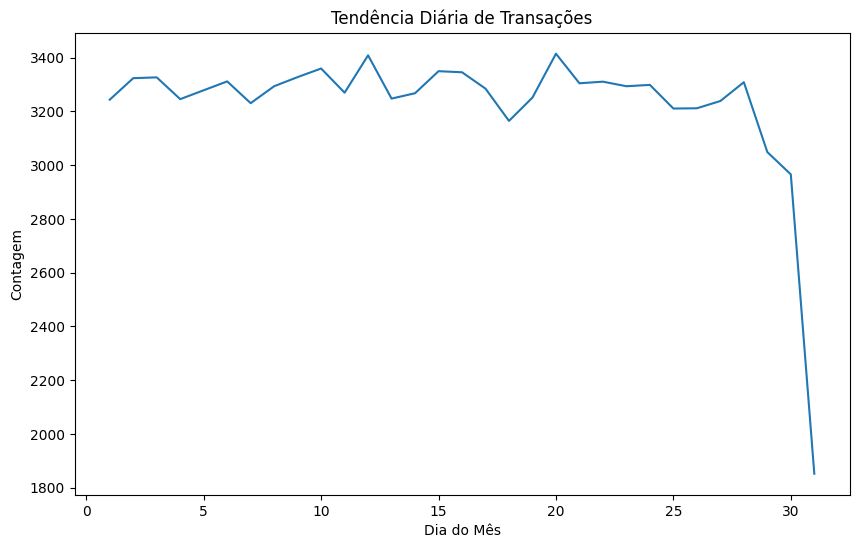

In [18]:
df = df.withColumn("day_of_week", dayofmonth("transaction_date"))
daily_trend = df.groupBy("day_of_week").count().orderBy("day_of_week").toPandas()
plt.figure(figsize=(10, 6))
sns.lineplot(x='day_of_week', y='count', data=daily_trend)
plt.title('Tendência Diária de Transações')
plt.xlabel('Dia do Mês')
plt.ylabel('Contagem')
plt.show()


In [19]:
df_flatten.describe().show()

+-------+-----------------+------------------+-----------+-------------------+---------+------------------+------------------+---------------+--------------+-----------------+------------------+-----------------+
|summary|     id_transacao|             valor|  categoria|   transaction_date|chave_pix|            fraude|    remetente_nome|remetente_banco|remetente_tipo|destinatario_nome|destinatario_banco|destinatario_tipo|
+-------+-----------------+------------------+-----------+-------------------+---------+------------------+------------------+---------------+--------------+-----------------+------------------+-----------------+
|  count|           100000|            100000|     100000|             100000|   100000|            100000|            100000|         100000|        100000|           100000|            100000|           100000|
|   mean|          50999.5|10303.358732200059|       NULL|               NULL|     NULL|           0.15367|              NULL|           NULL|      

/tmp/ipykernel_25212/1537681441.py:26: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='count', data=daily_trend, palette='viridis')


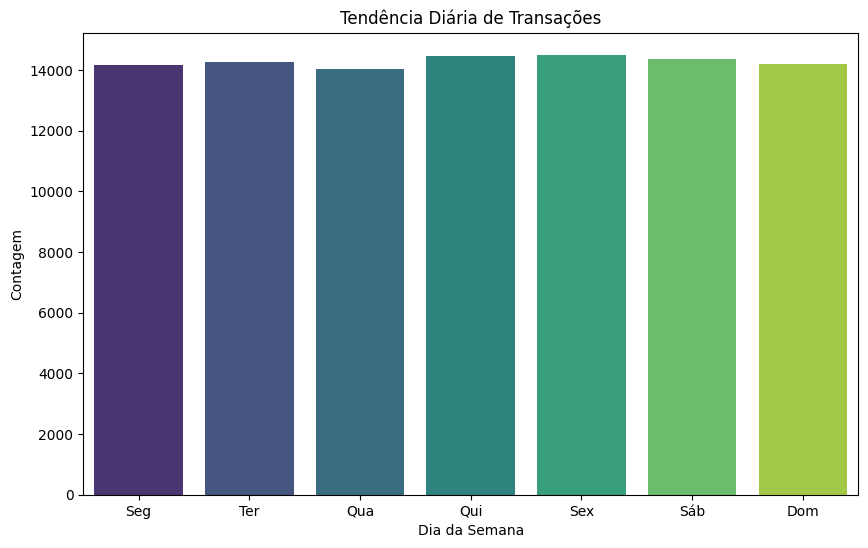

In [20]:
# Converter data
df = df.withColumn("transaction_date", col("transaction_date").cast("timestamp"))

# Adicionar coluna do dia da semana
df = df.withColumn("day_of_week_num", dayofweek("transaction_date"))

# Mapear números para nomes dos dias da semana
df = df.withColumn("day_of_week", when(col("day_of_week_num") == 1, "Dom")
                                  .when(col("day_of_week_num") == 2, "Seg")
                                  .when(col("day_of_week_num") == 3, "Ter")
                                  .when(col("day_of_week_num") == 4, "Qua")
                                  .when(col("day_of_week_num") == 5, "Qui")
                                  .when(col("day_of_week_num") == 6, "Sex")
                                  .when(col("day_of_week_num") == 7, "Sáb"))

# Agrupar e contar por dia da semana
daily_trend = df.groupBy("day_of_week").count().orderBy("day_of_week").toPandas()

# Ordenar dias da semana corretamente
order = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]
daily_trend['day_of_week'] = pd.Categorical(daily_trend['day_of_week'], categories=order, ordered=True)
daily_trend = daily_trend.sort_values("day_of_week")

# Plotar
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='count', data=daily_trend, palette='viridis')
plt.title('Tendência Diária de Transações')
plt.xlabel('Dia da Semana')
plt.ylabel('Contagem')
plt.show()

## <a id='toc1_5_'></a>[5 - Modelagem](#toc0_)

- Para qual banco esse cliente mais transfere?
- Qual é a média de transferências por período que esse cliente faz?
- Baseando-se no valor das transferências, poderia dar um aumento de crédito?
- Para o que esse cliente mais usa as transferências?
- Executar um algoritmo de machine learning que identifique possíveis transações com fraude.


In [21]:
# Para qual banco foram feitas mais transações?
df_flatten.groupBy('destinatario_banco').count().orderBy(col('count').desc()).show()


+------------------+-----+
|destinatario_banco|count|
+------------------+-----+
|                XP|14401|
|               BTG|14390|
|            Nubank|14297|
|              Itau|14281|
|             Caixa|14240|
|                C6|14204|
|          Bradesco|14187|
+------------------+-----+



In [22]:
# Quantas transações são realizadas por mês para cada banco?
df_flatten.groupBy(
    date_format('transaction_date', 'yyyy-MM').alias('ano_mes'), 'destinatario_banco'
    ).count().orderBy(col('ano_mes').desc()).show()

+-------+------------------+-----+
|ano_mes|destinatario_banco|count|
+-------+------------------+-----+
|2023-01|              Itau|  267|
|2023-01|             Caixa|  277|
|2023-01|                XP|  277|
|2023-01|          Bradesco|  280|
|2023-01|            Nubank|  290|
|2023-01|                C6|  290|
|2023-01|               BTG|  278|
|2022-12|                XP|  615|
|2022-12|               BTG|  603|
|2022-12|                C6|  576|
|2022-12|          Bradesco|  575|
|2022-12|            Nubank|  602|
|2022-12|              Itau|  633|
|2022-12|             Caixa|  616|
|2022-11|          Bradesco|  579|
|2022-11|               BTG|  580|
|2022-11|              Itau|  614|
|2022-11|            Nubank|  620|
|2022-11|             Caixa|  543|
|2022-11|                C6|  561|
+-------+------------------+-----+
only showing top 20 rows



In [23]:
# Valor de transação médio para cada banco
#df_flatten.groupBy('destinatario_banco').avg('valor').orderBy(col('avg(valor)').asc()).show()
average_df = df_flatten.groupBy('destinatario_banco').avg('valor')
formatted_average_df = average_df.withColumn('avg(valor)', format_number(col('avg(valor)'), 2))
formatted_average_df.orderBy(col('avg(valor)').desc()).show()


+------------------+----------+
|destinatario_banco|avg(valor)|
+------------------+----------+
|          Bradesco| 10,564.19|
|                XP| 10,328.07|
|            Nubank| 10,316.48|
|                C6| 10,309.50|
|             Caixa| 10,254.86|
|              Itau| 10,230.88|
|               BTG| 10,122.30|
+------------------+----------+



In [24]:
# Valor de transação total para cada banco
sum_df = df_flatten.groupBy('destinatario_banco').sum('valor')
formatted_sum_df = sum_df.withColumn('sum(valor)', format_number(col('sum(valor)'), 2))
formatted_sum_df.orderBy(col('sum(valor)').desc()).show()


+------------------+--------------+
|destinatario_banco|    sum(valor)|
+------------------+--------------+
|          Bradesco|149,874,228.63|
|                XP|148,734,558.71|
|            Nubank|147,494,648.81|
|                C6|146,436,134.80|
|              Itau|146,107,144.52|
|             Caixa|146,029,263.58|
|               BTG|145,659,894.17|
+------------------+--------------+



In [25]:
# total de transações por mês/banco por categoria
df_flatten.groupBy(
    date_format('transaction_date', 'yyyy-MM').alias('ano_mes'), 'destinatario_banco', 'categoria'
    ).count().orderBy(col('ano_mes').desc()).show()

+-------+------------------+-------------+-----+
|ano_mes|destinatario_banco|    categoria|count|
+-------+------------------+-------------+-----+
|2023-01|            Nubank|     educacao|   21|
|2023-01|               BTG|    presentes|   22|
|2023-01|              Itau|       outros|   27|
|2023-01|                XP|   transporte|   32|
|2023-01|               BTG|     educacao|   37|
|2023-01|            Nubank|        lazer|   29|
|2023-01|             Caixa|     educacao|   26|
|2023-01|             Caixa|        lazer|   21|
|2023-01|               BTG|        saude|   28|
|2023-01|                XP|        lazer|   26|
|2023-01|              Itau|     educacao|   30|
|2023-01|             Caixa|    presentes|   31|
|2023-01|            Nubank|    presentes|   25|
|2023-01|             Caixa|  alimentacao|   31|
|2023-01|                C6|  alimentacao|   30|
|2023-01|            Nubank|        saude|   34|
|2023-01|            Nubank|       outros|   35|
|2023-01|           

In [26]:
# total de transações por banco/categoria
df_flatten.groupBy('destinatario_banco', 'categoria'
    ).count().orderBy(col('categoria').desc()).show()

+------------------+-------------+-----+
|destinatario_banco|    categoria|count|
+------------------+-------------+-----+
|               BTG|    vestuario| 1384|
|                XP|    vestuario| 1351|
|              Itau|    vestuario| 1373|
|            Nubank|    vestuario| 1324|
|                C6|    vestuario| 1357|
|             Caixa|    vestuario| 1389|
|          Bradesco|    vestuario| 1325|
|            Nubank|   transporte| 1358|
|             Caixa|   transporte| 1306|
|               BTG|   transporte| 1357|
|              Itau|   transporte| 1313|
|                XP|   transporte| 1235|
|          Bradesco|   transporte| 1292|
|                C6|   transporte| 1313|
|          Bradesco|transferencia| 3593|
|              Itau|transferencia| 3533|
|             Caixa|transferencia| 3525|
|               BTG|transferencia| 3492|
|                XP|transferencia| 3557|
|                C6|transferencia| 3511|
+------------------+-------------+-----+
only showing top

In [27]:
# total de transações por categoria/ano
df_flatten.groupBy(
    date_format('transaction_date', 'yyyy').alias('ano'), 'categoria'
    ).count().orderBy(col('ano').desc()).show()

+----+-------------+-----+
| ano|    categoria|count|
+----+-------------+-----+
|2023|        saude|  193|
|2023|    vestuario|  174|
|2023|     educacao|  202|
|2023|    presentes|  163|
|2023|   transporte|  178|
|2023|  alimentacao|  189|
|2023|        lazer|  193|
|2023|transferencia|  475|
|2023|       outros|  192|
|2022|       outros| 4702|
|2022|        saude| 4784|
|2022|        lazer| 4784|
|2022|  alimentacao| 4799|
|2022|   transporte| 4593|
|2022|transferencia|12269|
|2022|    vestuario| 4731|
|2022|     educacao| 4681|
|2022|    presentes| 4687|
|2021|  alimentacao| 4560|
|2021|    presentes| 4404|
+----+-------------+-----+
only showing top 20 rows



In [28]:
# total de transações por categoria
df_flatten.groupBy('categoria').count().orderBy(col('count').desc()).show()

+-------------+-----+
|    categoria|count|
+-------------+-----+
|transferencia|24744|
|  alimentacao| 9548|
|    vestuario| 9503|
|        saude| 9476|
|        lazer| 9464|
|     educacao| 9460|
|       outros| 9377|
|    presentes| 9254|
|   transporte| 9174|
+-------------+-----+



In [29]:
# Quantidade de transações por ano
df_flatten.groupBy(date_format(col("transaction_date"), "yyyy").alias("ano")).agg(
    count("id_transacao").alias("qunt_transacoes")
).orderBy("ano", ascending=False).show()

+----+---------------+
| ano|qunt_transacoes|
+----+---------------+
|2023|           1959|
|2022|          50030|
|2021|          48011|
+----+---------------+



In [30]:
# valor total de transações por ano
df_flatten.groupBy(date_format(col("transaction_date"), "yyyy").alias("ano")).sum(
    "valor"
).select("ano", format_number(col("sum(valor)"), 2).alias("total_valor_transacoes")).orderBy(
    "ano", ascending=False
).show()

+----+----------------------+
| ano|total_valor_transacoes|
+----+----------------------+
|2023|         19,594,633.67|
|2022|        513,575,644.77|
|2021|        497,165,594.78|
+----+----------------------+



In [31]:
# valor médio de transações por ano
df_flatten.groupBy(date_format(col("transaction_date"), "yyyy").alias("ano")).avg(
    "valor"
).select("ano", format_number(col("avg(valor)"), 2).alias("media_transacoes")).orderBy(
    "ano", ascending=False
).show()

+----+----------------+
| ano|media_transacoes|
+----+----------------+
|2023|       10,002.37|
|2022|       10,265.35|
|2021|       10,355.24|
+----+----------------+



In [32]:
# Quantidade de fraudes
df_flatten.groupBy(col('fraude')).count().alias('quantidade').show()

+------+-----+
|fraude|count|
+------+-----+
|     1|15367|
|     0|84633|
+------+-----+



In [33]:
df_flatten.printSchema()

root
 |-- id_transacao: integer (nullable = true)
 |-- valor: double (nullable = true)
 |-- categoria: string (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- chave_pix: string (nullable = true)
 |-- fraude: integer (nullable = true)
 |-- remetente_nome: string (nullable = true)
 |-- remetente_banco: string (nullable = true)
 |-- remetente_tipo: string (nullable = true)
 |-- destinatario_nome: string (nullable = true)
 |-- destinatario_banco: string (nullable = true)
 |-- destinatario_tipo: string (nullable = true)



In [34]:
# Quantidade de transações por remetente
df_flatten.groupBy(col('remetente_nome')).count().alias('quantidade').show()

+------------------+------+
|    remetente_nome| count|
+------------------+------+
|Jonathan Gonsalves|100000|
+------------------+------+



In [35]:
# Quantidade de transações or tipo de chave pix
df_flatten.groupBy(col('chave_pix')).count().alias('quantidade').show()

+---------+-----+
|chave_pix|count|
+---------+-----+
|aleatoria|24810|
|  celular|24863|
|    email|25213|
|      cpf|25114|
+---------+-----+



In [36]:
# Quantidade de transações por destinatário
df_flatten.groupBy(col('destinatario_nome')).count().alias('quantidade').orderBy('count', ascending=False).show()

+--------------------+-----+
|   destinatario_nome|count|
+--------------------+-----+
|      Thomas Cardoso|   24|
|   Alexandre Cardoso|   22|
|   Ana Julia Cardoso|   22|
|     Ana Julia Gomes|   21|
|   Ana Julia Rezende|   20|
|    Stephany Cardoso|   20|
|       Maite Cardoso|   20|
|      Stella Cardoso|   20|
|        Julia Castro|   20|
|    Ana Julia Duarte|   20|
|Luiz Fernando Car...|   20|
| Maria Clara Cardoso|   19|
|Maria Sophia Cardoso|   19|
|     Julia Fernandes|   19|
|        Julia Moraes|   19|
|      Miguel Cardoso|   18|
|       Maysa Cardoso|   18|
|          Theo Nunes|   18|
|       Julia Costela|   18|
|      Bianca Cardoso|   18|
+--------------------+-----+
only showing top 20 rows



In [37]:
# Quantidade de fraudes por ano
df_flatten.filter(col("fraude") == 1).groupBy(
    date_format(col("transaction_date"), "yyyy").alias("ano")
).count().select("ano", format_number(col("count"), 2).alias("fraudes_ocorridas")).orderBy(
    "ano", ascending=False
).show()

+----+-----------------+
| ano|fraudes_ocorridas|
+----+-----------------+
|2023|           284.00|
|2022|         7,642.00|
|2021|         7,441.00|
+----+-----------------+



In [38]:
#verificar o total de fraudes por ano e tirar a prova dos valores comparados ao método anteriror

# Conta o número de fraudes por ano
df_yearly = df_flatten.filter(col("fraude") == 1).groupBy(
    date_format(col("transaction_date"), "yyyy").alias("ano")
).count().select(
    "ano", format_number(col("count"), 2).alias("total")
).orderBy(
    "ano", ascending=False
)

# Conta o número total de fraudes
df_total = df_flatten.filter(col("fraude") == 1).select(
    lit("Total").alias("ano"), format_number(count("*"), 2).alias("total")
)

# Adiciona a linha total ao DataFrame
df_result = df_yearly.union(df_total)

df_result.show()

+-----+---------+
|  ano|    total|
+-----+---------+
| 2023|   284.00|
| 2022| 7,642.00|
| 2021| 7,441.00|
|Total|15,367.00|
+-----+---------+



In [39]:
# Agrupamento por cateria e fraude
df_flatten.groupBy('fraude', 'categoria').count().orderBy('fraude', ascending =False).show()

+------+-------------+-----+
|fraude|    categoria|count|
+------+-------------+-----+
|     1|transferencia|15367|
|     0|   transporte| 9174|
|     0|        saude| 9476|
|     0|       outros| 9377|
|     0|    vestuario| 9503|
|     0|    presentes| 9254|
|     0|  alimentacao| 9548|
|     0|        lazer| 9464|
|     0|     educacao| 9460|
|     0|transferencia| 9377|
+------+-------------+-----+



In [40]:
# faixa de valores em que ocorreram fraudes

df_flatten.filter(col("fraude") == 1).withColumn(
    "range", floor(col("valor") / 1000) * 1000
).groupBy("range").count().orderBy("range").show()

+-----+-----+
|range|count|
+-----+-----+
|19000|    1|
|20000|  242|
|21000|  231|
|22000|  227|
|23000|  230|
|24000|  195|
|25000|  233|
|26000|  227|
|27000|  242|
|28000|  222|
|29000|  233|
|30000|  207|
|31000|  242|
|32000|  192|
|33000|  207|
|34000|  203|
|35000|  254|
|36000|  253|
|37000|  252|
|38000|  221|
+-----+-----+
only showing top 20 rows



In [41]:
# Faixa máxima e mínima de valores que ocorreram fraudes
df_flatten.filter(col("fraude") == 1).withColumn(
    "range", floor(col("valor") / 1000) * 1000
).select(
    format_number(max("range"), 0).alias('faixa_max_fraude'),
    min('range').alias('faixa_min_fraude')).show()

+----------------+----------------+
|faixa_max_fraude|faixa_min_fraude|
+----------------+----------------+
|          89,000|           19000|
+----------------+----------------+



## <a id='toc1_6_'></a>[6 - Modelo de Predição de Fraudes](#toc0_)

In [42]:
df_flatten.columns

['id_transacao',
 'valor',
 'categoria',
 'transaction_date',
 'chave_pix',
 'fraude',
 'remetente_nome',
 'remetente_banco',
 'remetente_tipo',
 'destinatario_nome',
 'destinatario_banco',
 'destinatario_tipo']

In [43]:
df.columns

['id_transacao',
 'valor',
 'remetente',
 'destinatario',
 'categoria',
 'transaction_date',
 'chave_pix',
 'fraude',
 'day_of_week',
 'day_of_week_num']

In [44]:
indexer = StringIndexer(
    inputCols=[
        "destinatario_nome", 
        "destinatario_banco",
        "destinatario_tipo",
        "categoria",
        "chave_pix"
    ], 
    outputCols=[
        "destinatario_nome_index", 
        "destinatario_banco_index",
        "destinatario_tipo_index",
        "categoria_index",
        "chave_pix_index"
    ])

In [45]:
df_index = indexer.fit(df_flatten).transform(df_flatten)
df_index.show()

24/06/07 17:56:02 WARN DAGScheduler: Broadcasting large task binary with size 1278.8 KiB


+------------+------------------+-------------+-------------------+---------+------+------------------+---------------+--------------+--------------------+------------------+-----------------+-----------------------+------------------------+-----------------------+---------------+---------------+
|id_transacao|             valor|    categoria|   transaction_date|chave_pix|fraude|    remetente_nome|remetente_banco|remetente_tipo|   destinatario_nome|destinatario_banco|destinatario_tipo|destinatario_nome_index|destinatario_banco_index|destinatario_tipo_index|categoria_index|chave_pix_index|
+------------+------------------+-------------+-------------------+---------+------+------------------+---------------+--------------+--------------------+------------------+-----------------+-----------------------+------------------------+-----------------------+---------------+---------------+
|        1000|            588.08|       outros|2021-07-16 05:00:55|aleatoria|     0|Jonathan Gonsalves|   

In [46]:
# para filtros, podemos usar somente colunas numéricas e de data
cols_para_filtrar = [
  "valor",
  "transaction_date",
  "destinatario_nome_index", 
  "destinatario_banco_index",
  "destinatario_tipo_index",
  "chave_pix_index",
  "categoria_index",
  "fraude"
]

In [47]:
is_fraud = df_index.select(cols_para_filtrar).filter(col("fraude") == 1)
not_fraud = df_index.select(cols_para_filtrar).filter(col("fraude") == 0)


In [48]:
# separar amostra dos dados de fraude
not_fraud = not_fraud.sample(False, 0.1, 42)

In [49]:
df_concat = not_fraud.union(is_fraud)
df = df_concat.sort("transaction_date")
df.count()

23712

In [50]:
train, test = df.randomSplit([0.7, 0.3], seed = 123)
print("train =", train.count(), " test =", test.count())

24/06/07 17:56:04 WARN DAGScheduler: Broadcasting large task binary with size 1290.0 KiB
24/06/07 17:56:06 WARN DAGScheduler: Broadcasting large task binary with size 1302.2 KiB
24/06/07 17:56:08 WARN DAGScheduler: Broadcasting large task binary with size 1296.6 KiB
24/06/07 17:56:08 WARN DAGScheduler: Broadcasting large task binary with size 1290.0 KiB
24/06/07 17:56:09 WARN DAGScheduler: Broadcasting large task binary with size 1302.2 KiB


train = 16504  test = 7208


24/06/07 17:56:11 WARN DAGScheduler: Broadcasting large task binary with size 1296.6 KiB


In [51]:
is_fraud = udf(lambda fraud: 1.0 if fraud > 0 else 0.0, DoubleType())
train = train.withColumn("is_fraud", is_fraud(train.fraude))

In [52]:
train.write.mode("overwrite").parquet(f"data{os.sep}stage{os.sep}train.parquet")

24/06/07 17:56:12 WARN DAGScheduler: Broadcasting large task binary with size 1290.0 KiB
24/06/07 17:56:13 WARN DAGScheduler: Broadcasting large task binary with size 1302.2 KiB
24/06/07 17:56:14 WARN DAGScheduler: Broadcasting large task binary with size 2041.6 KiB


In [53]:
# Create the feature vectors.
assembler = VectorAssembler(
  inputCols = [x for x in train.columns if x not in ["transaction_date", "fraude", "is_fraud"]],
  outputCol = "features")

# Use Logistic Regression.
lr = LogisticRegression().setParams(
    maxIter = 100000,
    labelCol = "is_fraud",
    predictionCol = "prediction")

spark = spark.builder.config("spark.network.timeout", "600s").getOrCreate()

# Repartition the train DataFrame into 4 partitions
# train = train.repartition()

# This will train a logistic regression model on the input data and return a 
# LogisticRegressionModel object which can be used to make predictions on new data.
model = Pipeline(stages = [assembler, lr]).fit(train)

24/06/07 17:56:17 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/06/07 17:56:17 WARN DAGScheduler: Broadcasting large task binary with size 1290.0 KiB
24/06/07 17:56:18 WARN DAGScheduler: Broadcasting large task binary with size 1302.2 KiB
24/06/07 17:56:20 WARN DAGScheduler: Broadcasting large task binary with size 1290.0 KiB
24/06/07 17:56:22 WARN DAGScheduler: Broadcasting large task binary with size 1302.2 KiB
24/06/07 17:56:24 WARN DAGScheduler: Broadcasting large task binary with size 1340.9 KiB
24/06/07 17:56:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/06/07 17:56:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/06/07 17:56:26 WARN DAGScheduler: Broadcasting large task binary with size 1341.6 KiB
24/06/07 17:56:27 WARN DAGScheduler: Broadcasting large task binary with size 1341.6 KiB
24/06/07 17:56:27 WARN DAGScheduler: Bro

In [54]:
# Transforma os dados de teste usando o modelo
predicted = model.transform(test)

# Adiciona uma nova coluna 'is_fraud' ao DataFrame
predicted = predicted.withColumn("is_fraud", is_fraud(predicted.fraude))

# Cria uma tabela de contingência (crosstab) entre 'is_fraud' e 'prediction'
crosstab_df = predicted.crosstab("is_fraud", "prediction")

# Converte os nomes das colunas para strings
crosstab_df = crosstab_df.toDF(*(c.replace('.', '_') for c in crosstab_df.columns))

# Calcula a soma total de todas as linhas
total = crosstab_df.select(*(col(c).cast("int") for c in crosstab_df.columns)).rdd.flatMap(lambda x: x).reduce(lambda x, y: x + y)

# Adiciona novas colunas ao DataFrame para mostrar as porcentagens
for column in crosstab_df.columns[1:]:
    crosstab_df = crosstab_df.withColumn(column + '_percent', round((col(column) / lit(total)) * 100, 2))

crosstab_df.show()

24/06/07 17:56:36 WARN DAGScheduler: Broadcasting large task binary with size 1290.0 KiB
24/06/07 17:56:38 WARN DAGScheduler: Broadcasting large task binary with size 1302.2 KiB
24/06/07 17:56:40 WARN DAGScheduler: Broadcasting large task binary with size 1339.8 KiB
24/06/07 17:56:40 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
24/06/07 17:56:40 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
24/06/07 17:56:40 WARN DAGScheduler: Broadcasting large task binary with size 1328.3 KiB
24/06/07 17:56:41 WARN DAGScheduler: Broadcasting large task binary with size 1290.0 KiB
24/06/07 17:56:42 WARN DAGScheduler: Broadcasting large task binary with size 1302.2 KiB
24/06/07 17:56:44 WARN DAGScheduler: Broadcasting large task binary with size 1346.0 KiB
24/06/07 17:56:44 WARN DAGScheduler: Broadcasting large task binary with size 1334.1 KiB
24/06/07 17:56:44 WARN DAGScheduler: Broadcasting large task binary with size 1344.4 KiB
24/06/07 17:56:46 WAR

+-------------------+----+----+-----------+-----------+
|is_fraud_prediction| 0_0| 1_0|0_0_percent|1_0_percent|
+-------------------+----+----+-----------+-----------+
|                1.0|   0|4636|        0.0|      64.31|
|                0.0|2571|   1|      35.66|       0.01|
+-------------------+----+----+-----------+-----------+



24/06/07 17:56:49 WARN DAGScheduler: Broadcasting large task binary with size 1334.8 KiB
24/06/07 17:56:49 WARN DAGScheduler: Broadcasting large task binary with size 1340.5 KiB


In [ ]:
df_flatten.printSchema()

root
 |-- id_transacao: integer (nullable = true)
 |-- valor: double (nullable = true)
 |-- categoria: string (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- chave_pix: string (nullable = true)
 |-- fraude: integer (nullable = true)
 |-- remetente_nome: string (nullable = true)
 |-- remetente_banco: string (nullable = true)
 |-- remetente_tipo: string (nullable = true)
 |-- destinatario_nome: string (nullable = true)
 |-- destinatario_banco: string (nullable = true)
 |-- destinatario_tipo: string (nullable = true)



# <a id='toc2_'></a>[Avaliação do Modelo](#toc0_)
Será que seu modelo atinge todas as necessidades que foram definidas inicialmente?



# <a id='toc3_'></a>[Deployment](#toc0_)
Apresente o relatório com os resultados obtidos.




  